# Forecasting inflation - random forest and neural network

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score


### I'm using US quarterly CPI observed between 1955 and 2024. The goal is to roughly compare the performance of three classes of predictors. It's a computational exercise to analyze the output. In a more rigorous exercise it would be interesting to benchmark these estimates with VAR models with stochastic volatility (see Chan, 2013).

In [8]:
data = pd.read_csv('US_CPI.csv')
print(data.head())

         date  inflation
0  01/04/1955   0.000000
1  01/07/1955   0.249222
2  01/10/1955  -0.123916
3  01/01/1956   0.000000
4  01/04/1956   0.495207


In [9]:
lags = 3
data = pd.DataFrame({'inflation': inflation})
for lag in range(1, lags+1):
    data[f'inflation_lag_{lag}'] = data['inflation'].shift(lag)
data = data.dropna().reset_index(drop=True)

In [10]:
X = data[[f'inflation_lag_{lag}' for lag in range(1, lags+1)]]
y = data['inflation']

In [11]:
print(data.head())

   inflation  inflation_lag_1  inflation_lag_2  inflation_lag_3
0   1.523030         0.000000         0.000000         0.000000
1   0.527362         1.523030         0.000000         0.000000
2  -0.427365         0.527362         1.523030         0.000000
3   1.511928        -0.427365         0.527362         1.523030
4   1.757080         1.511928        -0.427365         0.527362


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [13]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(100,50), 
                                  early_stopping=True,
                                  max_iter=500,
                                  random_state=42)
}

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
results = {}
for name, model in models.items():
    if name == "Neural Network":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    results[name] = {
        'MSE': mean_squared_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred),
        'y_pred': y_pred,
        'model': model
    }


In [18]:
print("\nModel Performance Comparison:")
for model, metrics in results.items():
    print(f"\n{model}:")
    print(f"MSE: {metrics['MSE']:.4f}")
    print(f"R²: {metrics['R²']:.4f}")


Model Performance Comparison:

Linear Regression:
MSE: 0.9892
R²: 0.1907

Random Forest:
MSE: 1.0404
R²: 0.1488

Neural Network:
MSE: 0.9915
R²: 0.1888


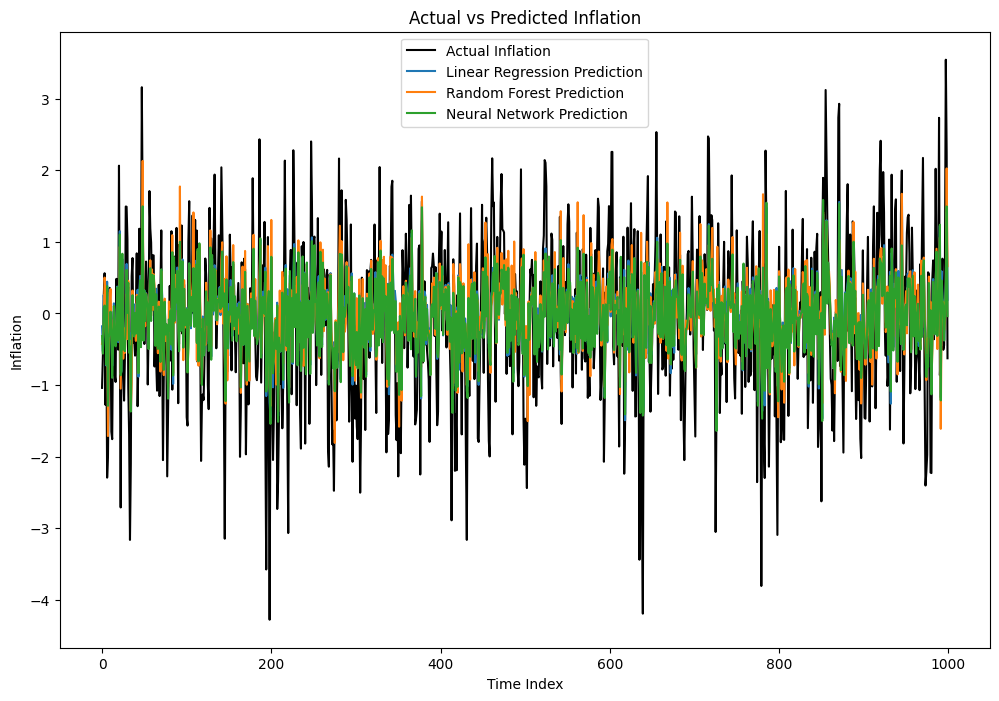

In [17]:
plt.figure(figsize=(12,8))
plt.plot(y_test.values, label='Actual Inflation', color='black')
for model_name, metrics in results.items():
    plt.plot(metrics['y_pred'], label=f'{model_name} Prediction')
plt.title('Actual vs Predicted Inflation')
plt.xlabel('Time Index')
plt.ylabel('Inflation')
plt.legend()
plt.show()

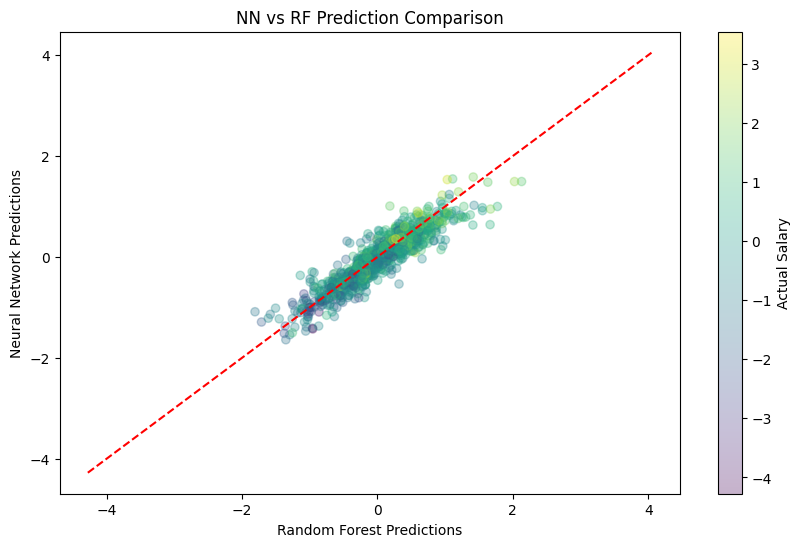

In [19]:
plt.figure(figsize=(10,6))
plt.scatter(results['Random Forest']['model'].predict(X_test), 
            results['Neural Network']['model'].predict(X_test_scaled),
            alpha=0.3, c=y_test, cmap='viridis')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.colorbar(label='Actual Salary')
plt.xlabel('Random Forest Predictions')
plt.ylabel('Neural Network Predictions')
plt.title('NN vs RF Prediction Comparison')
plt.show()

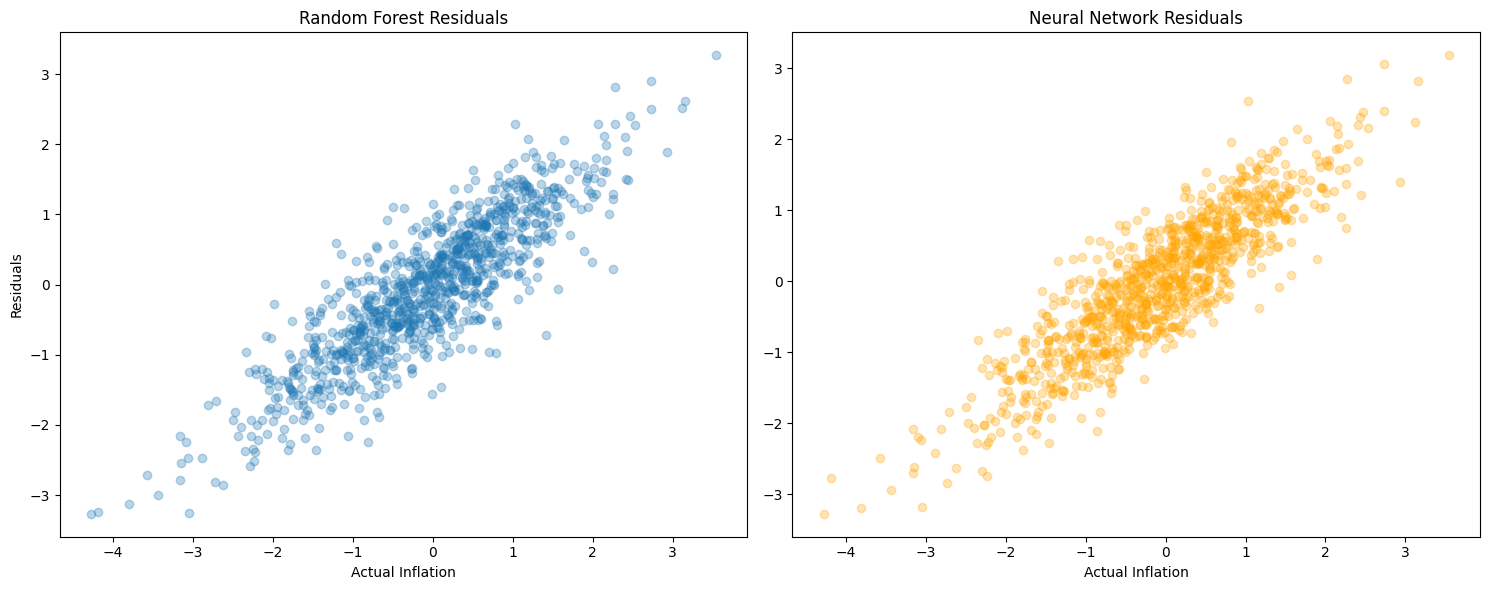

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# RF Residuals
rf_residuals = y_test - results['Random Forest']['model'].predict(X_test)
ax1.scatter(y_test, rf_residuals, alpha=0.3)
ax1.set_title('Random Forest Residuals')
ax1.set_xlabel('Actual Inflation')
ax1.set_ylabel('Residuals')

# NN Residuals
nn_residuals = y_test - results['Neural Network']['model'].predict(X_test_scaled)
ax2.scatter(y_test, nn_residuals, alpha=0.3, color='orange')
ax2.set_title('Neural Network Residuals')
ax2.set_xlabel('Actual Inflation')

plt.tight_layout()
plt.show()

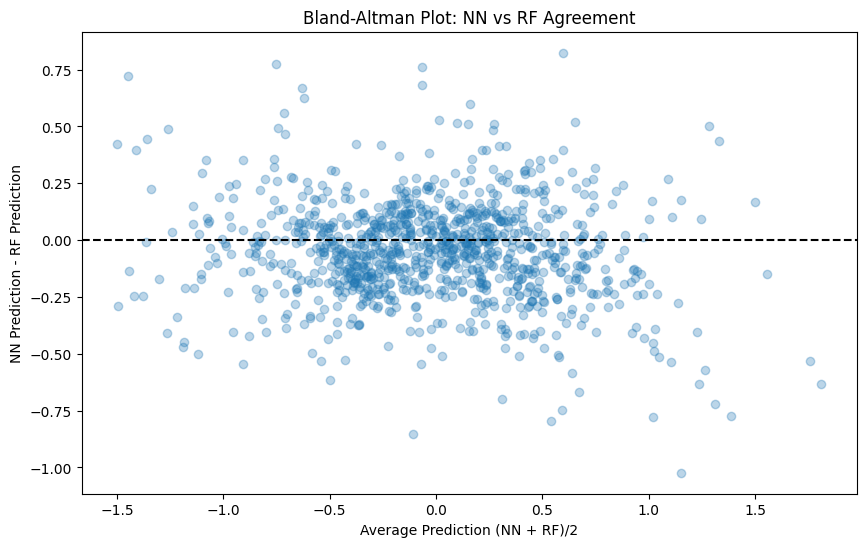

In [21]:
nn_pred = results['Neural Network']['model'].predict(X_test_scaled)
rf_pred = results['Random Forest']['model'].predict(X_test)

differences = nn_pred - rf_pred
averages = (nn_pred + rf_pred)/2

plt.figure(figsize=(10,6))
plt.scatter(averages, differences, alpha=0.3)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Average Prediction (NN + RF)/2')
plt.ylabel('NN Prediction - RF Prediction')
plt.title('Bland-Altman Plot: NN vs RF Agreement')
plt.show()

### No systematic bias between NN and RF. No indication of cluster heterogeneity, and spread is random.